In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/dacon

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/dacon


In [3]:
from utils.utils import *
from utils.Augmentation import *
from utils.intersection_over_union import IoU_np

# Single Human Detection Model

dacon에서 진행한 모션 키포인트 검출 AI 경진대회의 데이터를 기반으로 single human detection model을 개발한 과정을 정리하였습니다.

## Data Load & Preprocessing

In [4]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

train = train.sample(frac=1).reset_index(drop=True)
valid = valid.sample(frac=1).reset_index(drop=True)

### Image resize

In [5]:
train_val_dir = 'data/'
image1 = cv2.imread(train_val_dir + 'train/' + train['image'].iloc[0], cv2.COLOR_BGR2RGB)
image2 = cv2.imread(train_val_dir + 'train/' + train['image'].iloc[1], cv2.COLOR_BGR2RGB)
image3 = cv2.imread(train_val_dir + 'train/' + train['image'].iloc[2], cv2.COLOR_BGR2RGB)
image4 = cv2.imread(train_val_dir + 'train/' + train['image'].iloc[3], cv2.COLOR_BGR2RGB)

Ry = 0.4
Rx = 0.4
size = (int(image1.shape[0]*Ry), int(image1.shape[1]*Rx))

image1 = cv2.resize(image1, size[::-1])/255
image2 = cv2.resize(image2, size[::-1])/255
image3 = cv2.resize(image3, size[::-1])/255
image4 = cv2.resize(image4, size[::-1])/255

images = [image1, image2, image3, image4]

In [6]:
train_val_dir = 'data/'
image1_valid = cv2.imread(train_val_dir + 'val/' + valid['image'].iloc[0], cv2.COLOR_BGR2RGB)
image2_valid = cv2.imread(train_val_dir + 'val/' + valid['image'].iloc[1], cv2.COLOR_BGR2RGB)
image3_valid = cv2.imread(train_val_dir + 'val/' + valid['image'].iloc[2], cv2.COLOR_BGR2RGB)
image4_valid = cv2.imread(train_val_dir + 'val/' + valid['image'].iloc[3], cv2.COLOR_BGR2RGB)

Ry = 0.4
Rx = 0.4
size = (int(image1_valid.shape[0]*Ry), int(image1_valid.shape[1]*Rx))

image1_valid = cv2.resize(image1_valid, size[::-1])/255
image2_valid = cv2.resize(image2_valid, size[::-1])/255
image3_valid = cv2.resize(image3_valid, size[::-1])/255
image4_valid = cv2.resize(image4_valid, size[::-1])/255

images_valid = [image1_valid, image2_valid, image3_valid, image4_valid]

In [7]:
train = df_resize(train, Rx, Ry)
valid = df_resize(valid, Rx, Ry)

### Bounding Box Config Generating 

dacon에서 제공하는 data는 keypoints 추정이므로 bounding box에 대한 라벨은없습니다. 따라서 각 keypoints에서 x, y 좌표 최대, 최소값으로 bounding box를 설정 하기로 하였습니다.

하지만 key point data에서 단순히 최대 최소 값을 기준으로 bounding box를 설정하면 머리, 발, 손등이 잘리기 때문에 가로 세로를 확장하기로 하였습니다.

먼저 자세에 따라 최대 최소 값을 살펴 보고 bounding box를 확장하기 위한 기준을 잡기로 하였습니다.

1. y 최소값은 눈, 손(팔을 들고 있을때) 최댓값은 등(누워 있는 자세), 손 발(업드리거나 서있는 자세)
2. x 최대 최소 값은 손, 발, 눈(누워 있는 자세), 등 골반(구부린 자세의 옆모습)이 됩니다. 

각 자세에 따라 가로 세로 비율이 1~3배가 되고 누워서 두 팔을 편 자세일 경우 7배 까지 됩니다.
추가로 대부분 w가 길면 누워있는 경우, h가 길면 서 있는 경우임을 확인 하였습니다. 

결과로 다음과 같은 기준을 새웠습니다.
1. w가 길때, h가 길때 두 경우의 x, y에 곱해주는 비율을 다르게 할것
2. w, h의 비율이 3배 이상인 경우 팔을 들고 있는경우 이며 각각 확장해주는 값을 더 크게 설정할것
3. 비율이 비슷한 경우는 상체를 숙이고 있거나 벤치에 누워서 팔을 들어올린 경우가 있지만 위와 같이 처리하였을때 사람을 잘 포함하기 때문에 이 경우는 따로 처리 하지 않았습니다.

기준에 따라 가로 세로를 확장하고 비율이 극단적인 경우를 고려하여 추가로 조금의 확장을 적용하였습니다.

In [8]:
def ground_truth_generator(target):
    df = target.copy()
    df['ratio'] = df.apply(lambda x: (x['x_max'] - x['x_min']) / (x['y_max'] - x['y_min']), axis=1)

    df['y_max'] = df.apply(lambda x: x['y_max'] + (x['y_max'] - x['y_min'])* 0.3 if x['ratio'] > 3 else x['y_max'] + (x['y_max'] - x['y_min'])*.03  if x['ratio'] > 1 else x['y_max'], axis=1)    
    df['y_min'] = df.apply(lambda x: x['y_min'] - (x['y_max'] - x['y_min'])* 0.3 if x['ratio'] > 3 else x['y_min'] - (x['y_max'] - x['y_min'])*.03  if x['ratio'] > 1 else x['y_min'], axis=1)
    df['x_min'] = df.apply(lambda x: x['x_min'] - (x['x_max'] - x['x_min'])*.03 if x['ratio'] > 3 else x['x_min'] - (x['x_max'] - x['x_min'])*.05  if x['ratio'] > 1 else x['x_min'], axis=1)
    df['x_max'] = df.apply(lambda x: x['x_max'] + (x['x_max'] - x['x_min'])*.03 if x['ratio'] > 3 else x['x_max'] + (x['x_max'] - x['x_min'])*.05  if x['ratio'] > 1 else x['x_max'], axis=1)

    df['x_min'] = df.apply(lambda x: x['x_min'] - (x['x_max'] - x['x_min'])*0.3 if x['ratio'] < 1/3 else x['x_min'] - (x['x_max'] - x['x_min'])*.03 if x['ratio'] < 1 else x['x_min'], axis=1)
    df['x_max'] = df.apply(lambda x: x['x_max'] + (x['x_max'] - x['x_min'])*0.3 if x['ratio'] < 1/3 else x['x_max'] + (x['x_max'] - x['x_min'])*.03 if x['ratio'] < 1 else x['x_max'], axis=1)
    df['y_max'] = df.apply(lambda x: x['y_max'] + (x['y_max'] - x['y_min'])*.03 if x['ratio'] < 1/3 else x['y_max'] + (x['y_max'] - x['y_min'])*.05 if x['ratio'] < 1 else x['y_max'], axis=1)
    df['y_min'] = df.apply(lambda x: x['y_min'] - (x['y_max'] - x['y_min'])*.03 if x['ratio'] < 1/3 else x['y_min'] - (x['y_max'] - x['y_min'])*.05 if x['ratio'] < 1 else x['y_min'], axis=1)

    ground_truth = df.iloc[:,:1].copy() 
    ground_truth['x_min'] = df['x_min'] - (df['x_max'] - df['x_min'])*.03
    ground_truth['x_max'] = df['x_max'] + (df['x_max'] - df['x_min'])*.03
    ground_truth['y_max'] = df['y_max'] + (df['y_max'] - df['y_min'])*.03
    ground_truth['y_min'] = df['y_min'] - (df['y_max'] - df['y_min'])*.03

    ground_truth['w'] = ground_truth['x_max'] - ground_truth['x_min']
    ground_truth['h'] = ground_truth['y_max'] - ground_truth['y_min']
    ground_truth['x'] = ground_truth['w']/2 + ground_truth['x_min']
    ground_truth['y'] = ground_truth['h']/2 + ground_truth['y_min']
    return ground_truth

In [9]:
ground_truth = ground_truth_generator(train)
ground_truth_val = ground_truth_generator(valid)

GT = np.array(ground_truth[['x', 'y', 'w', 'h']])
GT_val = np.array(ground_truth_val[['x', 'y', 'w', 'h']])

### Anchor box

anchor box를 설정하기 위하여 다음을 고려하며 ground truth bounding box의 분포를 그래프, 눈으로 확인하고 scales, ratio값을 설정 하였습니다.

1. ground truth bounding box의 넓이 분포
2. w, h의 길이 비
3. anchor의 갯수

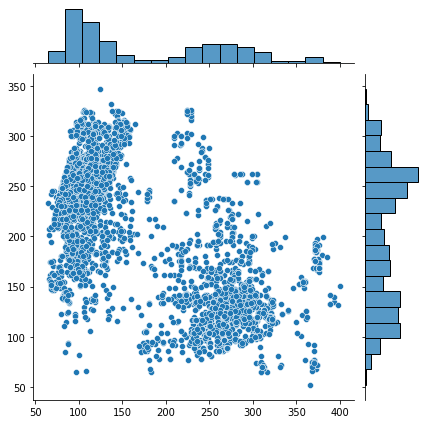

In [10]:
sns.jointplot(x=GT[:, 2], y=GT[:, 3])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


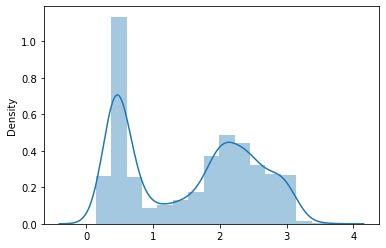

In [11]:
# h / w
sns.distplot(GT[:, 3] / GT[:, 2], kde=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


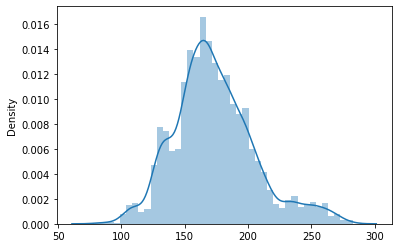

In [12]:
# w * h
sns.distplot(np.sqrt(GT[:, 2] * GT[:, 3]), kde=True)
plt.show()

결과로 5개의 scales, 5개의 ratio를 설정하였습니다.  
즉, faster-rcnn에서 K = 5\*5 가 되었습니다.

In [13]:
m = np.mean(np.sqrt(GT[:, 2] * GT[:, 3]))
s = np.std(np.sqrt(GT[:, 2] * GT[:, 3]))
# [125.11191814638539,
#  149.2321302947448,
#  173.3523424431042,
#  213.5526960237032,
#  253.7530496043022]
scales = [m - 1.5*s, m - 0.75*s, m, m + 1.25*s, m + 2.5*s]

ratio = [(1/np.sqrt(3), np.sqrt(3)), (1/np.sqrt(2), np.sqrt(2)), (1, 1), (np.sqrt(2), 1/np.sqrt(2)), (np.sqrt(3), 1/np.sqrt(3))]
anchor_boxes = Anchor_Boxes(image1.shape, scales, ratio, model='vgg')

bboxes = anchors_to_coordinates(anchor_boxes)
out_boundaries_indxes = (np.where(bboxes[:, 0] < 0) or np.where(bboxes[:, 2] < 0) or np.where(bboxes[:, 1] > 768) or np.where(bboxes[:, 3] > 432))[0]

ious : tf.Tensor([0.93408025 0.89641549 0.82733677 0.7936786  0.75497951], shape=(5,), dtype=float64)


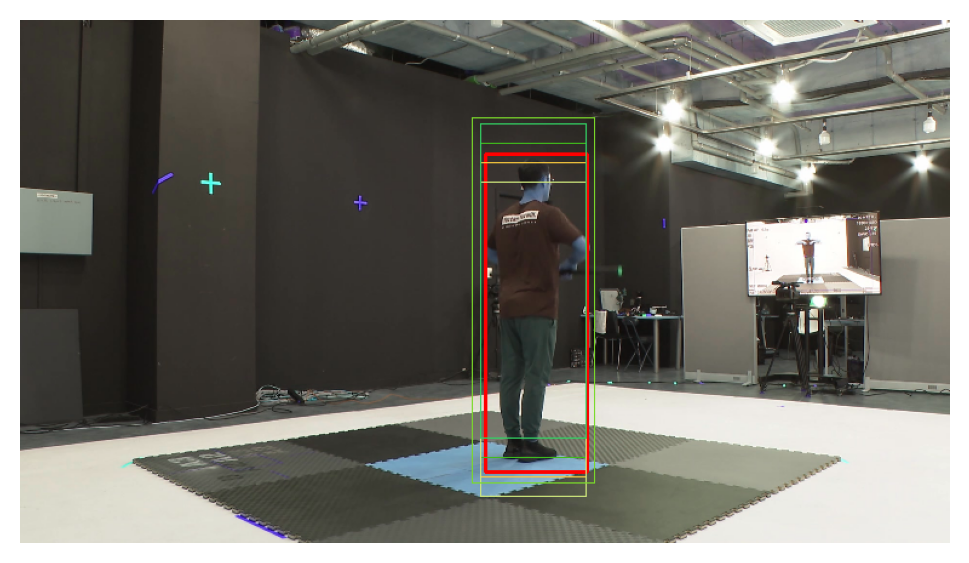

In [14]:
#@title IoU { run: "auto", vertical-output: true, display-mode: "form" }
image_num = 3 #@param [1, 2, 3, 4] {type:"raw"}
max_output_size = 5 #@param [1, 5, 10, 15, 20] {type:"raw"}

ground_truth_row = ground_truth.iloc[image_num-1]


img_ = cv2.imread(f'./res/train_imgs/{ground_truth_row["image"]}', cv2.COLOR_BGR2RGB)
img_ = cv2.resize(img_, size[::-1])

colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(max_output_size)}

x1 = int(ground_truth_row['x_min'])
x2 = int(ground_truth_row['x_max'])
y1 = int(ground_truth_row['y_min'])
y2 = int(ground_truth_row['y_max'])
cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)

gt = ground_truth_row[['x', 'y', 'w', 'h']]
ious = IoU_np(gt, anchor_boxes)

selected_indices = tf.image.non_max_suppression(anchor_boxes, ious, max_output_size=max_output_size, iou_threshold=.9)
anchors = tf.gather(anchor_boxes, selected_indices)
print('ious :', IoU_np(gt, anchors))

for i, anchor_box in enumerate(anchors):
    anchor_box = anchor_to_coordinate(anchor_box.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor_box[0]), int(anchor_box[2])), (int(anchor_box[1]), int(anchor_box[3])), 
        colors.get(i), 
        thickness=1
    )
    
fig, ax = plt.subplots(dpi=200)
ax.imshow(img_)
ax.axis('off')
plt.show()

### Ground Truth Generating & Datd Load

anchor box를 설정하였으니 ground truth와 비교하여 모델을 훈련시킬 label을 생성합니다. 
논문과 같이 각 anchor box들과 ground truth의 iou가 0.7이상인 box를 P, 0.3 이하인 box를 N으로 두고 나머지는 고려 하지 않습니다.

이때 P와 N의 비율이 1:1이 되도록 설정하기 위하여 이미지당 label 갯수를 설정 32로 설정 하였습니다. 
이는 데이터에서 이미지당 검출해야하는 사람이 단 한명이며, 자세가 다양하기 때문입니다.

In [15]:
def gt_generator(target):
    x_min = np.min(target[::2])
    x_max = np.max(target[::2])
    y_min = np.min(target[1::2])
    y_max = np.max(target[1::2])
    ratio = (x_max - x_min) / (y_max - y_min)

    y_max = y_max + (y_max - y_min)*.3 if ratio > 3 else y_max + (y_max - y_min)*.03  if ratio > 1 else y_max    
    y_min = y_min - (y_max - y_min)*.3 if ratio > 3 else y_min - (y_max - y_min)*.03  if ratio > 1 else y_min
    x_min = x_min - (x_max - x_min)*.03 if ratio > 3 else x_min - (x_max - x_min)*.05  if ratio > 1 else x_min
    x_max = x_max + (x_max - x_min)*.03 if ratio > 3 else x_max + (x_max - x_min)*.05  if ratio > 1 else x_max

    x_min = x_min - (x_max - x_min)*.3 if ratio < 1/3 else x_min - (x_max - x_min)*.03 if ratio < 1 else x_min
    x_max = x_max + (x_max - x_min)*.3 if ratio < 1/3 else x_max + (x_max - x_min)*.03 if ratio < 1 else x_max
    y_max = y_max + (y_max - y_min)*.03 if ratio < 1/3 else y_max + (y_max - y_min)*.05 if ratio < 1 else y_max
    y_min = y_min - (y_max - y_min)*.03 if ratio < 1/3 else y_min - (y_max - y_min)*.05 if ratio < 1 else y_min 

    ground_truth_x_min = x_min - (x_max - x_min)*.03
    ground_truth_x_max = x_max + (x_max - x_min)*.03
    ground_truth_y_min = y_min - (y_max - y_min)*.03
    ground_truth_y_max = y_max + (y_max - y_min)*.03

    ground_truth_w = ground_truth_x_max - ground_truth_x_min
    ground_truth_h = ground_truth_y_max - ground_truth_y_min
    ground_truth_x = ground_truth_w/2 + ground_truth_x_min
    ground_truth_y = ground_truth_h/2 + ground_truth_y_min
    return [ground_truth_x, ground_truth_y, ground_truth_w, ground_truth_h]
    
def label_generator(GT, anchor_boxes, out_boundaries_indxes):
    cls_label = - np.ones(shape=(anchor_boxes.shape[0]))
    pos_iou_threshold = 0.7
    neg_iou_threshold = 0.3
    n_sample = 32
    pos_ratio = 0.5
    n_pos = int(pos_ratio * n_sample)
    
    ious = np.apply_along_axis(IoU_np, 0, GT, anchor_boxes=anchor_boxes)
    cls_label[ious >= pos_iou_threshold] = 1
    cls_label[ious < neg_iou_threshold] = 0
    cls_label[np.argmax(ious)] = 1
    cls_label[out_boundaries_indxes] = -1

    pos_index = np.where(cls_label == 1)[0]
    if len(pos_index) > n_pos:
        disable_index = np.random.choice(
            pos_index,
            size = (len(pos_index) - n_pos),
            replace=False
        )
        cls_label[disable_index] = -1

    n_neg = n_sample - np.sum(cls_label == 1)
    neg_index = np.where(cls_label == 0)[0]
    if len(neg_index) > n_neg:
        disable_index = np.random.choice(
            neg_index, 
            size = (len(neg_index) - n_neg),             
            replace = False
        )
        cls_label[disable_index] = -1

    reg_label = anchor_boxes * np.broadcast_to(tf.cast(cls_label > 0, tf.int32), (4, len(cls_label))).T
    indices = np.where(reg_label != 0)[0][::4]
    x, y, w, h = GT[0], GT[1], GT[2], GT[3]

    tx = (x - reg_label[indices][:, 0]) / (reg_label[indices][:, 2])
    ty = (y - reg_label[indices][:, 1]) / (reg_label[indices][:, 3])
    tw = np.log(w / reg_label[indices][:, 2]) 
    th = np.log(h / reg_label[indices][:, 3]) 
    reg_label[indices] = np.stack([tx, ty, tw, th]).T

    return cls_label, reg_label

### Loader & Augmentation

data augmentation은 dacon에 코드를 공유하여 주신 분이 계셔서 조금 수정하여 사용 하였습니다.  
아래 링크에서 확인 해주세요   
[date augmentation](https://dacon.io/competitions/official/235701/codeshare/2383?page=2&dtype=recent)

In [18]:
# SQL loader
def traingtGenerator():
    for i in range(len(train)):
        img = base64.decodebytes(train.iloc[i]['image'])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [432, 768])/255

        target = list(train.iloc[0, 5:])
        gt = gt_generator(target)
        cls_label, reg_label = label_generator(gt, anchor_boxes, out_boundaries_indxes)

        yield img, (cls_label, reg_label, gt)

    for i in range(len(train)):
        img = base64.decodebytes(train.iloc[i]['image'])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [432, 768])/255

        target = list(train.iloc[0, 5:])
        img, target = left_right_flip(img, target)
        gt = gt_generator(target)
        cls_label, reg_label = label_generator(gt, anchor_boxes, out_boundaries_indxes)

        yield img, (cls_label, reg_label, gt)

    for i in range(len(train)):
        img = base64.decodebytes(train.iloc[i]['image'])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [432, 768])/255

        target = list(train.iloc[0, 5:])
        img_list, target_list = shift_images(img, target)
        for shifted_img, shifted_target in zip(img_list, target_list):
            gt = gt_generator(shifted_target)
            cls_label, reg_label = label_generator(gt, anchor_boxes, out_boundaries_indxes)

            yield shifted_img, (cls_label, reg_label, gt)

    for i in range(len(train)):
        img = base64.decodebytes(train.iloc[i]['image'])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [432, 768])/255

        target = list(train.iloc[0, 5:])
        noisy_img = add_noise(img)
        gt = gt_generator(target)
        cls_label, reg_label = label_generator(gt, anchor_boxes, out_boundaries_indxes)

        yield noisy_img, (cls_label, reg_label, gt)

In [19]:
def valGenerator():
    Rx, Ry = 0.4, 0.4
    image_size = (1080, 1920, 3)
    size = [int(image_size[0] * Rx), int(image_size[1] * Ry)]

    for i in range(len(valid)):
        img = tf.io.read_file(train_val_dir + 'val/' + valid['image'].iloc[i]) 
        img = tf.image.decode_jpeg(img, channels=3) 
        img = tf.image.resize(img, size) 
        img = img/255     

        target = list(valid.iloc[:,1:49].iloc[i,:])
        gt = gt_generator(target)
        cls_label, reg_label = label_generator(gt, anchor_boxes, out_boundaries_indxes)         

        yield img, (cls_label, reg_label, gt)

In [20]:
train_dataset = tf.data.Dataset.from_generator(
    traingtGenerator,
    output_signature = (
            tf.TensorSpec(shape=(size[0], size[1], 3)),
            (
                tf.TensorSpec(shape=(len(anchor_boxes))),
                tf.TensorSpec(shape=(len(anchor_boxes),4)),
                tf.TensorSpec(shape=(4))
            )
        )
)

In [21]:
valid_dataset = tf.data.Dataset.from_generator(
    valGenerator,
    output_signature = (
            tf.TensorSpec(shape=(size[0], size[1], 3)),
            (
                tf.TensorSpec(shape=(len(anchor_boxes))),
                tf.TensorSpec(shape=(len(anchor_boxes),4)),
                tf.TensorSpec(shape=(4))
            )
        )
)

## Region Proposal Network

### Backborn

backborn은 imagenet에서 훈련된 VGG16, resnet50, resnet101을 사용합니다.  
성능차는 VGG16 < resnet50 < resnet101 이지만 resnet101은 무겁기 때문에 resnet50을 기본으로 사용하였습니다.

In [22]:
def get_base(img_size, model='resnet50'):
    if model=='vgg':
        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_size)
        feature_extractor = base_model.get_layer("block5_conv3")
    elif model == 'resnet101':
        base_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet', input_shape=img_size)
        feature_extractor = base_model.get_layer("conv4_block23_out")
    elif model == 'resnet50':
        base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=img_size)
        feature_extractor = base_model.get_layer("conv4_block6_out")  
    else:
        raise Exception('vgg, resnet')

    base_model = tf.keras.models.Model(inputs=base_model.input, outputs=feature_extractor.output)
    return base_model

### RPN

faster rcnn의 region proposal network 구현입니다.

각 anchor box에서 object가 존재하는지 판단하는 cls branch와 object가 존재한다면 bounbing박스를 예측하는 bbox_reg branch를 이루어져 있습니다. cls의 경우 위에서 -1로 설정한 anchor는 무시하고 loss를 계산합니다. bbox reg의 경우 iou가 0.7 이상인 값에서만 계산 합니다.

또한 rpn_lambda는 이미지당 label의 갯수인 n_sample과 anchor box의 갯수인 num_of_anchor의 비율인 10\*\*3으로 설정 하였습니다.

In [23]:
class RPN(tf.keras.models.Model):
    def __init__(self, img_size, anchor_boxes, k=5*5, n_sample=32, backbone='resnet50', rpn_lambda=10, **kwargs):
        super(RPN, self).__init__(**kwargs)
        self.img_size = img_size
        self.anchor_boxes = tf.convert_to_tensor(anchor_boxes, tf.float32)
        self.num_of_anchor = self.anchor_boxes.shape[0]
        self.n_sample = n_sample
        self.k = k
        self.backbone = backbone
        self.rpn_lambda = rpn_lambda

        self.base_model = get_base(self.img_size, model=self.backbone)
        self.window = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', name='window')
        self.window_bn = tf.keras.layers.BatchNormalization(name='window_bn')
        self.window_relu = tf.keras.layers.ReLU(name='window_relu')

        self.bbox_reg = tf.keras.layers.Conv2D(filters=self.k*4, kernel_size=1, name='bbox_reg')
        self.bbox_reg_reshape = tf.keras.layers.Reshape((-1, 4), name='reg_out')
        self.cls = tf.keras.layers.Conv2D(filters=self.k, kernel_size=1, activation='sigmoid', name='cls')
        self.cls_reshape = tf.keras.layers.Reshape((-1, 1), name='cls_out')

    def compile(self, optimizer, **kwargs):
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.test_loss_tracker = tf.keras.metrics.Mean(name='test_loss')
        self.optimizer = optimizer
        super(RPN, self).compile(**kwargs)
    
    def Cls_Loss(self, y_true, y_pred):
        indices = tf.where(tf.not_equal(y_true, tf.constant(-1.0, dtype=tf.float32)))
        target = tf.gather_nd(y_true, indices)
        output = tf.gather_nd(y_pred, indices)
        return tf.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM)(target, output)/self.n_sample

    def Reg_Loss(self, y_true, y_pred):
        indices = tf.reduce_any(tf.not_equal(y_true, 0), axis=-1)
        return tf.losses.Huber(reduction=tf.losses.Reduction.SUM)(y_true[indices], y_pred[indices])/self.num_of_anchor
    
    @tf.function
    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        
        with tf.GradientTape() as tape:
            cls, bbox_reg, _ = self(x, training=True)
            cls_loss = self.Cls_Loss(y_cls, cls)
            reg_loss = self.Reg_Loss(y_reg, bbox_reg)
            losses = cls_loss + self.rpn_lambda * reg_loss
            
        trainable_vars = self.trainable_variables
        grad = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(grad, trainable_vars))
        self.loss_tracker.update_state(losses)
        return {'rpn_loss': self.loss_tracker.result()}

    @tf.function
    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        
        cls, bbox_reg, _ = self(x, training=False)
        cls_loss = self.Cls_Loss(y_cls, cls)
        reg_loss = self.Reg_Loss(y_reg, bbox_reg)
        losses = cls_loss + self.rpn_lambda * reg_loss

        self.test_loss_tracker.update_state(losses)
        return {'rpn_loss_val': self.test_loss_tracker.result()}

    def bbox_regression(self, boxes):
        tx = (boxes[:, :, 0] - self.anchor_boxes[:, 0]) / self.anchor_boxes[:, 2]
        ty = (boxes[:, :, 1] - self.anchor_boxes[:, 1]) / self.anchor_boxes[:, 3]
        tw = tf.math.log(tf.maximum(boxes[:, :, 2], np.finfo(np.float64).eps) / self.anchor_boxes[:, 2])
        th = tf.math.log(tf.maximum(boxes[:, :, 3], np.finfo(np.float64).eps) / self.anchor_boxes[:, 3])
        return tf.stack([tx, ty, tw, th], -1)

    def inverse_bbox_regression(self, boxes):
        gx = self.anchor_boxes[:, 2] * boxes[:, :, 0] + self.anchor_boxes[:, 0]
        gy = self.anchor_boxes[:, 3] * boxes[:, :, 1] + self.anchor_boxes[:, 1]
        gw = self.anchor_boxes[:, 2] * tf.exp(boxes[:, :, 2])
        gh = self.anchor_boxes[:, 3] * tf.exp(boxes[:, :, 3])
        return tf.stack([gx, gy, gw, gh], axis=-1)
        
    def call(self, inputs):
        feature_extractor = self.base_model(inputs)
        intermediate = self.window(feature_extractor)
        intermediate = self.window_bn(intermediate)
        intermediate = self.window_relu(intermediate)

        cls = self.cls(intermediate)
        cls = self.cls_reshape(cls)
        bbox_reg = self.bbox_reg(intermediate)
        bbox_reg = self.bbox_reg_reshape(bbox_reg)
        bbox_reg = self.bbox_regression(bbox_reg)
        return cls, bbox_reg, feature_extractor

rpn을 통과하여 나온 값에 NMS를 적용하기 전에 아래의 과정을 거쳐 box들을 걸러냅니다.
1. x, y 좌표가 이미지의 사이즈를 넘어가는 경우 clip
3. confidence score가 높은 순으로 정렬후 상위 n_pre_nms개의 box들만 추출

In [24]:
class get_candidate_layer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(get_candidate_layer, self).__init__(**kwargs)

    def anchors_clip(self, boxes, size=(432, 768)):    
        x1 = boxes[:, :, 0] - boxes[:, :, 2]/2
        x2 = boxes[:, :, 0] + boxes[:, :, 2]/2
        y1 = boxes[:, :, 1] - boxes[:, :, 3]/2
        y2 = boxes[:, :, 1] + boxes[:, :, 3]/2
        
        x1 = tf.clip_by_value(x1, 0, size[1])
        x2 = tf.clip_by_value(x2, 0, size[1])
        y1 = tf.clip_by_value(y1, 0, size[0])
        y2 = tf.clip_by_value(y2, 0, size[0])

        w = x2 - x1
        h = y2 - y1
        x = x1 + w/2
        y = y1 + h/2
        return tf.stack([x, y, w, h], axis=-1)

    def call(self, x):
        scores, rps, n_pre_nms = x
        rois = self.anchors_clip(rps)

        oobw = tf.expand_dims(tf.cast(tf.math.greater(rois[:, :, 2], 16), tf.float32), -1)
        oobh = tf.expand_dims(tf.cast(tf.math.greater(rois[:, :, 3], 16), tf.float32), -1)
        scores = tf.math.multiply(scores, oobw)
        scores = tf.math.multiply(scores, oobh)

        orders = tf.argsort(scores, direction='DESCENDING', axis=1)[:, :n_pre_nms]
        rois = tf.gather_nd(rois, orders, batch_dims=1)
        scores = tf.gather_nd(scores, orders, batch_dims=1)
        return rois, scores

get_candidate_layer를 통과하여 나온 후보 지역들을 non maximum suppression을 통하여 고정된 갯수(max_output_size개)만 추출합니다.

In [25]:
class NMS(tf.keras.layers.Layer):
    def __init__(self, iou_threshold=0.5, **kwargs):
        self.iou_threshold = iou_threshold
        super(NMS, self).__init__(**kwargs)

    def call(self, inputs):
        rois, scores, max_output_size = inputs
        selected_indices_padded = tf.image.non_max_suppression_padded(
            rois, 
            tf.squeeze(scores), 
            max_output_size=max_output_size,
            iou_threshold=self.iou_threshold,
            pad_to_max_output_size=True
        )[0]
        nms = tf.gather(rois, selected_indices_padded, batch_dims=1)
        return nms

### RoI Pooling

NMS를 통해 나온 지역들은 classifier의 inputs으로 입력되기 위해 roi pooling을 합니다.   
mask rcnn구현을 찾아보던중 tf.image.crop_and_resize함수가 roi align의 수행과 같은 process라고 하여 간단히 구현 할 수 있었습니다.

In [37]:
class RoIpool(tf.keras.layers.Layer):
    def __init__(self, pool_size=7, **kwargs):
        self.pool_size = pool_size
        super(RoIpool, self).__init__(**kwargs)

    def cal_rois_ratio(self, nmses, size=[432, 768]):
        x1 = (nmses[:, :, 0] - nmses[:, :, 2]/2)/size[1]
        x2 = (nmses[:, :, 0] + nmses[:, :, 2]/2)/size[1]
        y1 = (nmses[:, :, 1] - nmses[:, :, 3]/2)/size[0]
        y2 = (nmses[:, :, 1] + nmses[:, :, 3]/2)/size[0]
        return tf.stack([y1, x1, y2, x2], axis=-1)

    def call(self, inputs):
        feature_map, nmses = inputs
        n_channel = feature_map.shape[-1]
        batch_size = nmses.shape[0]
        if batch_size is None:
            batch_size = 16
        num_rois = nmses.shape[1]
        nmses = self.cal_rois_ratio(nmses)
        rois = tf.image.crop_and_resize(
            feature_map, 
            tf.reshape(nmses, (-1, 4)), 
            box_indices=tf.convert_to_tensor([i for i in range(batch_size) for _ in range(num_rois)]), 
            crop_size=[self.pool_size, self.pool_size]
        )
        return tf.reshape(rois, shape=(batch_size, num_rois, self.pool_size, self.pool_size, n_channel))

## Classifier Label Generation

classifier를 구현하기 전에 다시 한번 label generator를 구현합니다.

confidence score를 기준으로 rpn과 nms를 통과한 box들의 iou를 계산하여 0.5 이상은 P, 이하는 N으로 설정하였습니다.

In [26]:
def get_iou(rois, gts):
    box1_area = tf.cast(rois[:, :, 2] * rois[:, :, 3], tf.float64)
    box2_area = tf.cast(gts[:, 2] * gts[:, 3], tf.float64)
    
    x1 = tf.maximum(tf.cast(rois[:, :, 0] - rois[:, :, 2]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 0] - gts[:, 2]/2, -1), tf.float64))
    x2 = tf.minimum(tf.cast(rois[:, :, 0] + rois[:, :, 2]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 0] + gts[:, 2]/2, -1), tf.float64))
    y1 = tf.maximum(tf.cast(rois[:, :, 1] - rois[:, :, 3]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 1] - gts[:, 3]/2, -1), tf.float64))
    y2 = tf.minimum(tf.cast(rois[:, :, 1] + rois[:, :, 3]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 1] + gts[:, 3]/2, -1), tf.float64))
    
    h = tf.maximum(tf.constant(0.0, dtype=tf.float64), y2 - y1)
    w = tf.maximum(tf.constant(0.0, dtype=tf.float64), x2 - x1)
    
    intersect = tf.math.multiply(h, w)
    union = tf.subtract(tf.add(box1_area, tf.expand_dims(box2_area, -1)), intersect) + 1e-12
    return tf.divide(intersect, union)

In [28]:
@tf.function
def classifier_label_generator(nms, gts, valid=False, num_roi=256, pos_ratio=0.25, pos_iou_threshold=0.5, neg_iou_threshold=0.5):
    num_pos = int(num_roi * pos_ratio)
    num_neg = int(num_roi - num_pos)
    ious = get_iou(nms, gts)
    pos_order = tf.argsort(ious * tf.cast(tf.math.greater_equal(ious, pos_iou_threshold), tf.float64), direction='DESCENDING', axis=1)[:, :num_pos]
    neg_order = tf.argsort(ious * tf.cast(tf.math.less(ious, neg_iou_threshold), tf.float64), direction='DESCENDING', axis=1)[:, :num_neg]
    
    if not valid:
        neg_cnt = tf.reduce_min(tf.math.count_nonzero(ious * tf.cast(tf.math.less(ious, neg_iou_threshold), tf.float64), axis=1))
        neg_order = tf.argsort(ious * tf.cast(tf.math.less(ious, neg_iou_threshold), tf.float64), direction='DESCENDING', axis=1)[:, :neg_cnt]
        indices = tf.range(start=0, limit=neg_cnt, dtype=tf.int32)
        shuffled_indices = tf.random.shuffle(indices)
        neg_order = tf.gather(neg_order, shuffled_indices, axis=1)[:, :num_neg]

    cls_labels = tf.concat([tf.ones_like(pos_order), tf.zeros_like(neg_order)], axis=1)
    label_order = tf.concat([pos_order, neg_order], axis=1)
    # P_boxes = tf.gather(nms, label_order, batch_dims=1)
    P_boxes = nms
    
    tx = (gts[:, :1] - P_boxes[:, :, 0]) / P_boxes[:, :, 2]
    ty = (gts[:, 1:2] - P_boxes[:, :, 1]) / P_boxes[:, :, 3]
    tw = tf.math.log(gts[:, 2:3] / P_boxes[:, :, 2]) 
    th = tf.math.log(gts[:, 3:] / P_boxes[:, :, 3]) 
    
    box_labels = tf.stack([tx, ty, tw, th], axis=-1)
    return box_labels, cls_labels, (pos_order, label_order), P_boxes

## Classifier

### Feature Extractor

In [38]:
def resnet_C5():
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg')
    roi_inputs = tf.keras.Input(shape=(7, 7, 1024))

    first_layer = tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 1), strides=(1, 1))
    first_layer(roi_inputs)
    first_layer.set_weights(base_model.layers[143].get_weights())

    x = first_layer(roi_inputs)
    for i in range(144, 148+1):
        x = base_model.layers[i](x)
    x = base_model.layers[150](x)
    x = base_model.layers[152](x)

    short_cut_layer = tf.keras.layers.Conv2D(filters=2048, kernel_size=(1, 1), strides=(1, 1))
    short_cut_layer(roi_inputs)
    short_cut_layer.set_weights(base_model.layers[149].get_weights())

    short_cut = short_cut_layer(roi_inputs)
    short_cut = base_model.layers[151](short_cut)
    x = base_model.layers[153]([x, short_cut])
    short_cut = base_model.layers[154](x)

    for i in range(155, 162+1):
        x = base_model.layers[i](x)
    x = base_model.layers[163]([x, short_cut])
    short_cut = base_model.layers[164](x)

    for i in range(165, 172+1):
        x = base_model.layers[i](x)
    x = base_model.layers[173]([x, short_cut])
    x = base_model.layers[174](x)
    output = base_model.layers[175](x)
    return tf.keras.models.Model(inputs=roi_inputs, outputs=output)

### Classifier

Classifier는 각 이미지당 여려개의 roi가 존재 하기 때문에 TimeDistributed를 통하여 구현하였습니다.

전체 적인 구조는 논문을 따르지만 rcnn에서 classifer는 object별로 confidence score와 bounding box regression을 수행하는데 주어진 데이터와 task는 단 한명의 사람만 검출하면 되므로 rpn과 비슷한 과정을 거칩니다.

하이퍼파라미터 탐색과 batch norm을 추가하여 훈련에 안정성을 주었습니다.

In [39]:
class Classifier(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super(Classifier, self).__init__(**kwargs)
        self.cls_lambda = 10
        self.res5 = resnet_C5()

        self.cls_dense = tf.keras.layers.Dense(256, name='cls_dense')
        self.cls_bn = tf.keras.layers.BatchNormalization(name='cls_bn')
        self.cls_relu = tf.keras.layers.ReLU(name='cls_relu')
        self.cls = tf.keras.layers.Dense(1, activation='sigmoid', name='cls_out')

        self.bbox_dense = tf.keras.layers.Dense(256, name='bbox_dense')
        self.bbox_bn = tf.keras.layers.BatchNormalization(name='bbox_bn')
        self.bbox_relu = tf.keras.layers.ReLU(name='bbox_relu')
        self.bbox_reg = tf.keras.layers.Dense(4, name='bbox_out')

    def compile(self, optimizer):
        super(Classifier, self).compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.test_loss_tracker = tf.keras.metrics.Mean(name='test_loss')

    def Cls_Loss(self, y_true, y_pred, label_order):
        y_pred = tf.gather(y_pred, label_order, batch_dims=1)
        return tf.losses.BinaryCrossentropy()(y_true, y_pred)

    def Reg_Loss(self, y_true, y_pred, pos_order):
        y_true = tf.gather(y_true, pos_order, batch_dims=1)
        y_pred = tf.gather(y_pred, pos_order, batch_dims=1)
        return tf.losses.Huber()(y_true, y_pred)

    @tf.function(experimental_relax_shapes=True)
    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        orders = y[2]
        pos_order, label_order = orders
        
        with tf.GradientTape() as tape:
            cls, bbox_reg, _ = self(x, training=True)
            cls_loss = self.Cls_Loss(y_cls, cls, label_order)
            reg_loss = self.Reg_Loss(y_reg, bbox_reg, pos_order)
            losses = cls_loss + self.cls_lambda * reg_loss 
            
        trainable_vars = self.trainable_variables
        grad = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(grad, trainable_vars))
        self.loss_tracker.update_state(losses)
        return {'classifier_loss': self.loss_tracker.result()}

    @tf.function(experimental_relax_shapes=True)
    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        orders = y[2]
        pos_order, label_order = orders

        cls, bbox_reg, _ = self(x, training=False)
        cls_loss = self.Cls_Loss(y_cls, cls, label_order)
        reg_loss = self.Reg_Loss(y_reg, bbox_reg, pos_order)
        losses = cls_loss + self.cls_lambda * reg_loss 

        self.test_loss_tracker.update_state(losses)
        return {'classifier_loss_val': self.test_loss_tracker.result()}

    
    def bbox_regression(self, bbox, nmses):
        tx = (bbox[:, :, 0] - nmses[:, :, 0]) / nmses[:, :, 2]
        ty = (bbox[:, :, 1] - nmses[:, :, 1]) / nmses[:, :, 3]
        tw = tf.math.log(tf.maximum(bbox[:, :, 2], np.finfo(np.float64).eps) / nmses[:, :, 2])
        th = tf.math.log(tf.maximum(bbox[:, :, 3], np.finfo(np.float64).eps) / nmses[:, :, 3])
        return tf.stack([tx, ty, tw, th], -1)

    @staticmethod
    def inverse_bbox_regression(bbox, nmses):
        gx = nmses[:, :, 2] * bbox[:, :, 0] + nmses[:, :, 0]
        gy = nmses[:, :, 3] * bbox[:, :, 1] + nmses[:, :, 1]
        gw = nmses[:, :, 2] * tf.exp(bbox[:, :, 2])
        gh = nmses[:, :, 3] * tf.exp(bbox[:, :, 3])
        return tf.stack([gx, gy, gw, gh], -1)

    def call(self, inputs):
        rois, nms = inputs
        feature_vector = tf.keras.layers.TimeDistributed(self.res5)(rois)

        cls_x = tf.keras.layers.TimeDistributed(self.cls_dense)(feature_vector)
        cls_x = tf.keras.layers.TimeDistributed(self.cls_bn)(cls_x)
        cls_x = tf.keras.layers.TimeDistributed(self.cls_relu)(cls_x)
        clss = tf.keras.layers.TimeDistributed(self.cls)(cls_x)
        
        bbox_x = tf.keras.layers.TimeDistributed(self.bbox_dense)(feature_vector)
        bbox_x = tf.keras.layers.TimeDistributed(self.bbox_bn)(bbox_x)
        bbox_x = tf.keras.layers.TimeDistributed(self.bbox_relu)(bbox_x)
        bbox = tf.keras.layers.TimeDistributed(self.bbox_reg)(bbox_x)
        bbox_reg = self.bbox_regression(bbox, nms)
        return clss, bbox_reg, nms

## Faster RCNN

rpn, roipooling, nms, classifier를 합친 Faster_RCNN을 구현하였습니다.   
training stage가 나누어져 있어 train_step을 따로 구현하여 훈련되도록 하였습니다.

In [43]:
class Faster_RCNN(tf.keras.models.Model):
    def __init__(self, img_size, anchor_boxes, k, n_sample, backbone, rpn_lambda, pool_size, **kwargs):
        super(Faster_RCNN, self).__init__(*kwargs)
        self.img_size = img_size
        self.anchor_boxes = anchor_boxes
        self.k = k
        self.n_sample = n_sample
        self.backbone = backbone
        self.rpn_lambda = rpn_lambda
        self.pool_size = pool_size
        self.n_train_pre_nms = 6000
        self.n_train_post_nms = 512
        self.n_test_pre_nms = 6000
        self.n_test_post_nms = 256
        self.iou_threshold = 0.7

        self.rpn = RPN(
            img_size= self.img_size, 
            anchor_boxes=self.anchor_boxes, 
            k=self.k, 
            n_sample=self.n_sample, 
            backbone=self.backbone, 
            rpn_lambda=self.rpn_lambda,
            name='rpn'
            )
        self.get_candidate = get_candidate_layer(name='get_candidate')
        self.get_nms = NMS(iou_threshold=self.iou_threshold, name='get_nms')
        self.roipool = RoIpool(pool_size=self.pool_size, name='roipool')
        self.classifier = Classifier(name='classifier')

    def compile(self, rpn_optimizer, classifier_optimizer):
        self.rpn.compile(optimizer=rpn_optimizer)
        self.classifier.compile(optimizer=classifier_optimizer)
        super(Faster_RCNN, self).compile()

    def call(self, inputs):
        scores, rps, feature_map = self.rpn(inputs)
        rps = self.rpn.inverse_bbox_regression(rps)
        candidate_area, scores = self.get_candidate((scores, rps, self.n_train_pre_nms))
        nms = self.get_nms((candidate_area, scores, self.n_train_post_nms))
        rois = self.roipool((feature_map, nms))
        cls, bbox_reg, nms = self.classifier((rois, nms))
        predict = self.classifier.inverse_bbox_regression(bbox_reg, nms)
        return cls, predict

In [44]:
tf.keras.backend.clear_session()

img_size=image1.shape
anchor_boxes=anchor_boxes
k=5*5
n_sample=32
backbone='resnet50'
rpn_lambda=10**3
pool_size=7

frcnn = Faster_RCNN(
    img_size=img_size, 
    anchor_boxes=anchor_boxes, 
    k=k, 
    n_sample=n_sample, 
    backbone=backbone,
    rpn_lambda=rpn_lambda, 
    pool_size=pool_size
)

frcnn.compile(
    rpn_optimizer = tf.keras.optimizers.Adam(lr=0.01),
    classifier_optimizer = tf.keras.optimizers.Adam(lr=0.001)
)

# frcnn.load_weights("./saved_model/step1")
# frcnn.load_weights("./saved_model/step2_2")
# frcnn.load_weights("./saved_model/step3_2")
frcnn.load_weights("./saved_model/step4_2")

### Faster rcnn train step


train stage는 다음 4단계로 구성됩니다.
1. RPNs 훈련합니다.
2. rpn는 고정하고 shared convolutional layer를 훈련합니다.
3. shared convolutional layers는 고정하고 RPN을 훈련합니다.
4. Fast R-CNN부분만 훈련합니다.

In [45]:
def frcnn_train_step(model, train_dataset, train_stage, epochs=1, valid_dataset=None, change_lr=False, rpn_lr=None, cls_lr=None):    
    if change_lr:
        if rpn_lr:
            tf.keras.backend.set_value(model.rpn.optimizer.learning_rate, rpn_lr)
        if cls_lr:
            tf.keras.backend.set_value(model.classifier.optimizer.learning_rate, cls_lr)

    if train_stage == 1:
        print('Train RPNs \n')
        model.rpn.trainable = True
        model.classifier.trainable = False
    elif train_stage == 2:
        print('Train Fast R-CNN using the proposals from RPNs \n')
        model.rpn.trainable = False
        model.rpn.base_model.trainable = True
        model.classifier.trainable = True
    elif train_stage == 3:
        print('Fix the shared convolutional layers and fine-tune unique layers to RPN \n')
        model.rpn.trainable = True
        model.rpn.base_model.trainable = False
        model.classifier.trainable = False
    elif train_stage == 4:
        print('Fine-tune unique layers to Fast R-CNN \n')
        model.rpn.trainable = False
        model.classifier.trainable = True

    max_step = 'Unknown'
    for epoch in tf.range(epochs):
        epoch_start = time.time()
        print(f"epoch {epoch+1}/{epochs}")
        display_loss = display("Training loss at step 0 : 0", display_id=True)
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            start = time.time()
            y_cls_rpn, y_reg_rpn, gts = y_batch_train
            
            if train_stage == 1 or train_stage == 3:
                result = model.rpn.train_step((x_batch_train, (y_cls_rpn, y_reg_rpn)))
                losses = round(float(result['rpn_loss'].numpy()), 5)
            else:
                scores, rps, feature_map = model.rpn(x_batch_train, training=False)
                if train_stage == 2:
                    model.rpn.train_step((x_batch_train, (y_cls_rpn, y_reg_rpn)))
                rps = model.rpn.inverse_bbox_regression(rps)
                candidate_area, scores = model.get_candidate((scores, rps, model.n_train_pre_nms))
                nms = model.get_nms((candidate_area, scores, model.n_train_post_nms))
                box_labels, cls_labels, orders, nms = classifier_label_generator(nms, gts)
                # box_labels, cls_labels, nms = classifier_label_generator(nms, gts)
                rois = model.roipool((feature_map, nms))
                result = model.classifier.train_step(((rois, nms), (cls_labels, box_labels, orders)))
                # result = model.classifier.train_step(((rois, nms), (cls_labels, box_labels)))
                losses = round(float(result['classifier_loss'].numpy()), 5)

            display_loss.update(f"Training loss at step {step}/{max_step} : {losses} - {round(time.time() - start, 4)}sec/step - {time.strftime('%Hh%Mm%Ss', time.gmtime(time.time()-epoch_start))}/epoch")
        max_step = step
        display_loss.update(f"Training loss at step {step}/{max_step} : {losses} - {round(time.time()-start, 4)}sec/step - {time.strftime('%Hh%Mm%Ss', time.gmtime(time.time()-epoch_start))}/epoch")

        if valid_dataset is not None:
            display_loss_valid = display("validation loss : 0", display_id=True)
            for x_batch_test, y_batch_test in valid_dataset:
                y_cls_rpn, y_reg_rpn, gts = y_batch_test

                if train_stage == 1 or train_stage == 3:
                    result = model.rpn.test_step((x_batch_test, (y_cls_rpn, y_reg_rpn)))
                    losses = round(float(result['rpn_loss_val'].numpy()), 5)
                else:
                    scores, rps, feature_map = model.rpn.predict(x_batch_test)
                    rps = model.rpn.inverse_bbox_regression(rps)
                    candidate_area, scores = model.get_candidate((scores, rps, model.n_test_pre_nms))
                    nms = model.get_nms((candidate_area, scores, model.n_test_post_nms))
                    box_labels, cls_labels, orders, nms = classifier_label_generator(nms, gts, valid=True)
                    # box_labels, cls_labels, nms = classifier_label_generator(nms, gts, valid=True)
                    rois = model.roipool((feature_map, nms))
                    result = model.classifier.test_step(((rois, nms), (cls_labels, box_labels, orders)))
                    # result = model.classifier.test_step(((rois, nms), (cls_labels, box_labels)))
                    losses = round(float(result['classifier_loss_val'].numpy()), 5)
                
            display_loss_valid.update(f"validation loss : {losses}")

    return model

## Model train

In [46]:
batch_size = 4
train_dataset = train_dataset.batch(batch_size).prefetch(batch_size*2)
valid_dataset = valid_dataset.batch(batch_size).prefetch(batch_size*2) 

In [47]:
inputs = tf.stack(images)
gts = np.stack([GT[0], GT[1], GT[2], GT[3]])

In [48]:
inputs_valid = tf.stack(images_valid)
gts_valid = np.stack([GT_val[0], GT_val[1], GT_val[2], GT_val[3]])

### Step 1
Train RPNs 

In [49]:
# frcnn = frcnn_train_step(
#     model=frcnn, 
#     train_dataset=train_dataset, 
#     valid_dataset=valid_dataset,
#     train_stage=1,
#     change_lr=False, 
#     rpn_lr=None, 
#     cls_lr=None,
#     epochs=10
# )

In [50]:
# frcnn.save_weights("./saved_model/step1")

In [51]:
scores, rps, feature_map = frcnn.rpn.predict(inputs)
rps = frcnn.rpn.inverse_bbox_regression(rps)
candidate_area, scores = frcnn.get_candidate((scores, rps, frcnn.n_train_pre_nms))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


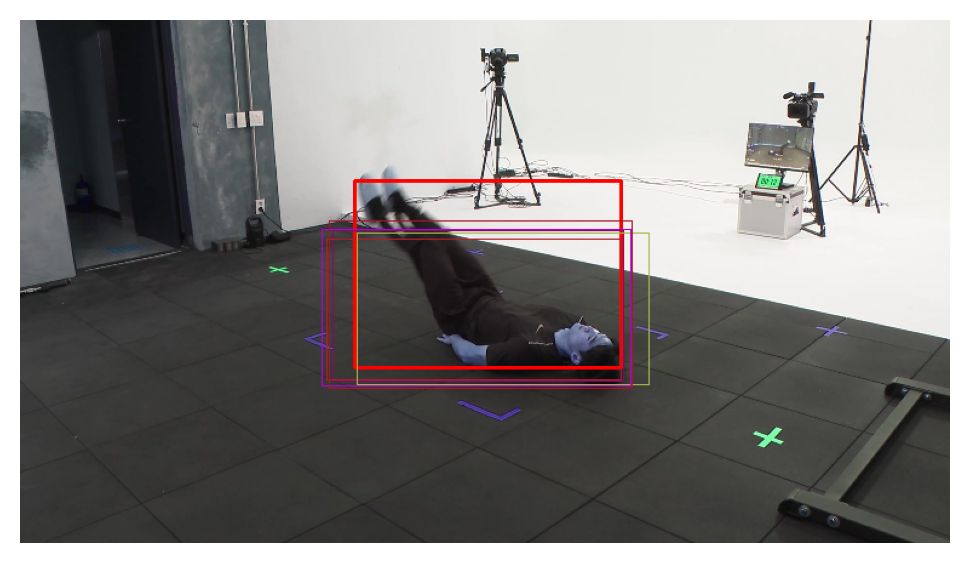

In [52]:
# @title RPN output after train step 1 { run: "auto", vertical-output: true, display-mode: "form" }
image_num = 4 #@param [1, 2, 3, 4] {type:"raw"}
max_output_size = 5 #@param [5, 10, 50, 100] {type:"raw"}

img_num = images[image_num-1]
img_ = img_num.copy()
candidate_area_ = candidate_area[image_num-1]
scores_ = scores[image_num-1]
ground_truth_row_ = ground_truth.iloc[image_num-1]

colors = {k: tuple(map(float, np.random.randint(0, 255, 3)/255)) for k in range(max_output_size)}

x1 = int(ground_truth_row_['x_min'])
x2 = int(ground_truth_row_['x_max'])
y1 = int(ground_truth_row_['y_min'])
y2 = int(ground_truth_row_['y_max'])
cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)

scores_order = tf.argsort(scores_, direction='DESCENDING', axis=0)
boxes = tf.squeeze(tf.gather(candidate_area_, scores_order))
boxes = boxes[boxes[:, 2] > 16]
boxes = boxes[boxes[:, 3] > 16][:max_output_size]

for i, anchor in enumerate(boxes):
    anchor = anchor_to_coordinate(anchor.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor[0]), int(anchor[2])), (int(anchor[1]), int(anchor[3])), 
        colors.get(i), 
        thickness=1
    )
fig, ax = plt.subplots(dpi=200)
ax.imshow(img_)
ax.axis('off')
plt.show()

### Step 2
Train Fast R-CNN using the proposals from RPNs

In [ ]:
# frcnn = frcnn_train_step(
#     model=frcnn, 
#     train_dataset=train_dataset, 
#     valid_dataset=valid_dataset,
#     train_stage=2,
#     change_lr=False, 
#     rpn_lr=None, 
#     cls_lr=None,
#     epochs=2
# )

In [71]:
# frcnn.save_weights("./saved_model/step2_2")

In [72]:
cls, predict = frcnn(inputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


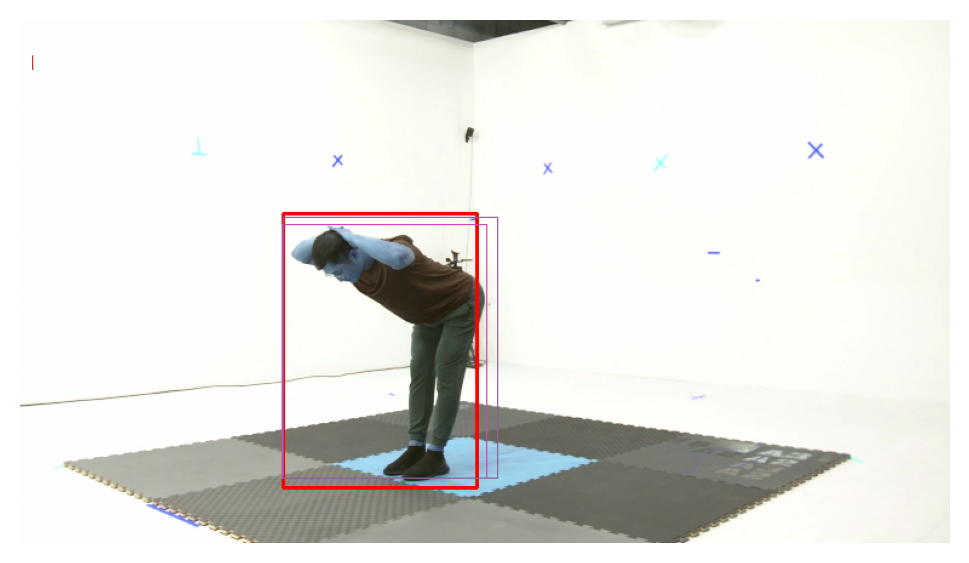

In [74]:
# @title Classifier output after train step 2 { run: "auto", vertical-output: true, display-mode: "form" }
image_num = 1 #@param [1, 2, 3, 4] {type:"raw"}
max_output_size = 5 #@param [2, 5, 10, 50, 100] {type:"raw"}

img_num = images[image_num-1]
img_ = img_num.copy()
candidate_area_ = predict[image_num-1]
scores_ = cls[image_num-1]
ground_truth_row_ = ground_truth.iloc[image_num-1]

colors = {k: tuple(map(float, np.random.randint(0, 255, 3)/255)) for k in range(max_output_size)}

x1 = int(ground_truth_row_['x_min'])
x2 = int(ground_truth_row_['x_max'])
y1 = int(ground_truth_row_['y_min'])
y2 = int(ground_truth_row_['y_max'])
cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)

scores_order = tf.argsort(scores_, direction='DESCENDING', axis=0)
boxes = tf.squeeze(tf.gather(candidate_area_, scores_order))
boxes = boxes[boxes[:, 2] > 16]
boxes = boxes[boxes[:, 3] > 16][:max_output_size]

for i, anchor in enumerate(boxes):
    anchor = anchor_to_coordinate(anchor.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor[0]), int(anchor[2])), (int(anchor[1]), int(anchor[3])), 
        colors.get(i), 
        thickness=1
    )


fig, ax = plt.subplots(dpi=200)
ax.imshow(img_)
ax.axis('off')
plt.show()

### Step 3
Fix the shared convolutional layers and fine-tune unique layers to RPN

In [ ]:
# frcnn = frcnn_train_step(
#     model=frcnn, 
#     train_dataset=train_dataset, 
#     valid_dataset=valid_dataset,
#     train_stage=3,
#     change_lr=True, 
#     rpn_lr=0.001, 
#     cls_lr=None,
#     epochs=5
# )

In [77]:
# frcnn.save_weights("./saved_model/step3_2")

In [78]:
scores, rps, feature_map = frcnn.rpn.predict(inputs)
rps = frcnn.rpn.inverse_bbox_regression(rps)
candidate_area, scores = frcnn.get_candidate((scores, rps, frcnn.n_train_pre_nms))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


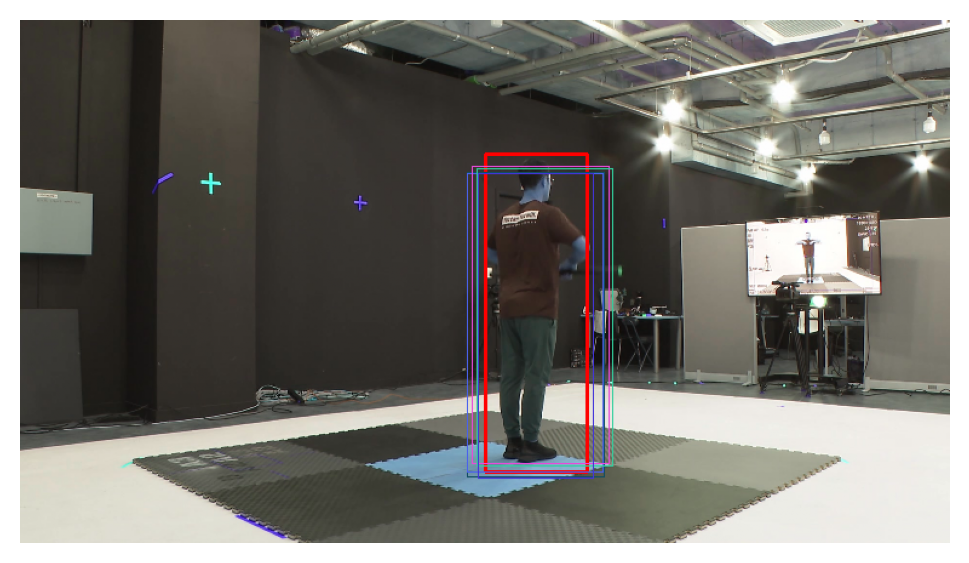

In [83]:
# @title RPN output after train step 3 { run: "auto", vertical-output: true, display-mode: "form" }
image_num = 3 #@param [1, 2, 3, 4] {type:"raw"}
max_output_size = 5 #@param [3, 5, 10, 50, 100] {type:"raw"}

img_num = images[image_num-1]
img_ = img_num.copy()
candidate_area_ = candidate_area[image_num-1]
scores_ = scores[image_num-1]
ground_truth_row_ = ground_truth.iloc[image_num-1]

colors = {k: tuple(map(float, np.random.randint(0, 255, 3)/255)) for k in range(max_output_size)}

x1 = int(ground_truth_row_['x_min'])
x2 = int(ground_truth_row_['x_max'])
y1 = int(ground_truth_row_['y_min'])
y2 = int(ground_truth_row_['y_max'])
cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)

scores_order = tf.argsort(scores_, direction='DESCENDING', axis=0)
boxes = tf.squeeze(tf.gather(candidate_area_, scores_order))
boxes = boxes[boxes[:, 2] > 16]
boxes = boxes[boxes[:, 3] > 16][:max_output_size]

for i, anchor in enumerate(boxes):
    anchor = anchor_to_coordinate(anchor.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor[0]), int(anchor[2])), (int(anchor[1]), int(anchor[3])), 
        colors.get(i), 
        thickness=1
    )
fig, ax = plt.subplots(dpi=200)
ax.imshow(img_)
ax.axis('off')
plt.show()

### Step 4
Fine-tune unique layers to Fast R-CNN

In [ ]:
# frcnn = frcnn_train_step(
#     model=frcnn, 
#     train_dataset=train_dataset, 
#     valid_dataset=valid_dataset,
#     train_stage=4,
#     change_lr=True, 
#     rpn_lr=None, 
#     cls_lr=0.0001,
#     epochs=5
# )

In [85]:
# frcnn.save_weights("./saved_model/step4_2")

In [86]:
cls, predict = frcnn(inputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


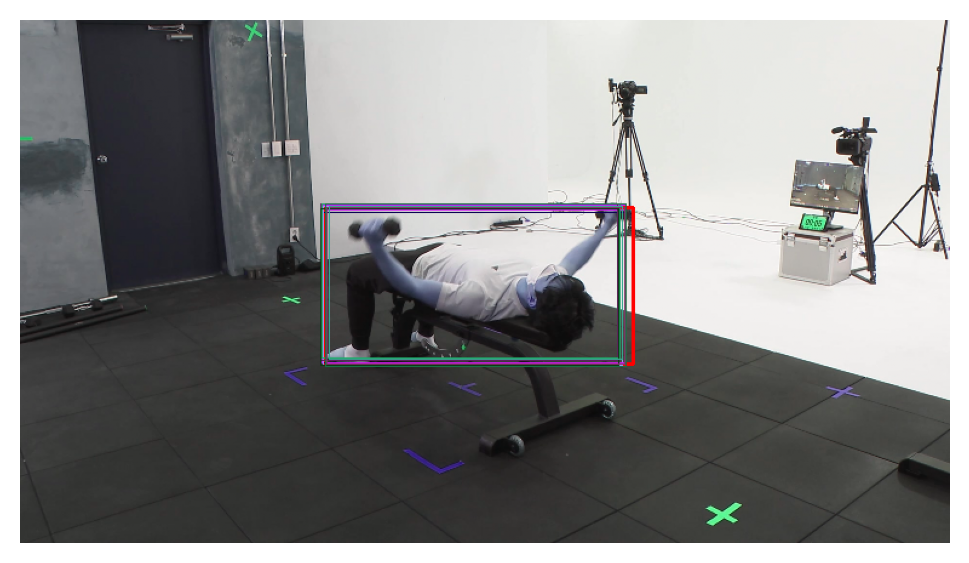

In [94]:
# @title Faster-RCNN output after train step 4 { run: "auto", vertical-output: true, display-mode: "form" }
image_num = 2 #@param [1, 2, 3, 4] {type:"raw"}
max_output_size = 10 #@param [3, 5, 10, 50, 100] {type:"raw"}

img_num = images[image_num-1]
img_ = img_num.copy()
candidate_area_ = predict[image_num-1]
scores_ = cls[image_num-1]
ground_truth_row_ = ground_truth.iloc[image_num-1]

colors = {k: tuple(map(float, np.random.randint(0, 255, 3)/255)) for k in range(max_output_size)}

x1 = int(ground_truth_row_['x_min'])
x2 = int(ground_truth_row_['x_max'])
y1 = int(ground_truth_row_['y_min'])
y2 = int(ground_truth_row_['y_max'])
cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)

scores_order = tf.argsort(scores_, direction='DESCENDING', axis=0)
boxes = tf.squeeze(tf.gather(candidate_area_, scores_order))
boxes = boxes[boxes[:, 2] > 16]
boxes = boxes[boxes[:, 3] > 16][:max_output_size]

for i, anchor in enumerate(boxes):
    anchor = anchor_to_coordinate(anchor.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor[0]), int(anchor[2])), (int(anchor[1]), int(anchor[3])), 
        colors.get(i), 
        thickness=1
    )


fig, ax = plt.subplots(dpi=200)
ax.imshow(img_)
ax.axis('off')
plt.show()

## Test Data

In [120]:
test_dir = './res/test_imgs/'
test = pd.read_csv('./res/sample_submission.csv')

In [121]:
image1_test = cv2.imread(test_dir + test['image'].iloc[0], cv2.COLOR_BGR2RGB)
image2_test = cv2.imread(test_dir + test['image'].iloc[1], cv2.COLOR_BGR2RGB)
image3_test = cv2.imread(test_dir + test['image'].iloc[2], cv2.COLOR_BGR2RGB)
image4_test = cv2.imread(test_dir + test['image'].iloc[3], cv2.COLOR_BGR2RGB)

image1_test = cv2.resize(image1_test, size[::-1])/255
image2_test = cv2.resize(image2_test, size[::-1])/255
image3_test = cv2.resize(image3_test, size[::-1])/255
image4_test = cv2.resize(image4_test, size[::-1])/255

images_test = [image1_test, image2_test, image3_test, image4_test]
inputs_test = tf.stack(images_test)

In [122]:
cls_test, predict_test = frcnn(inputs_test)

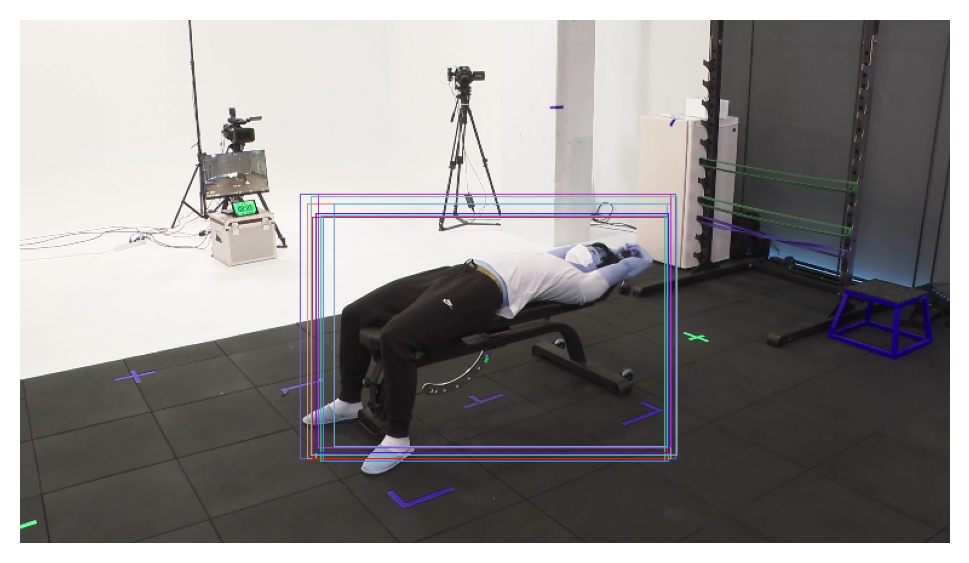

In [148]:
# @title Faster-RCNN output after train step 4 { run: "auto", vertical-output: true, display-mode: "form" }
image_num = 1 #@param [1, 2, 3, 4] {type:"raw"}
max_output_size = 10 #@param [3, 5, 10, 50, 100] {type:"raw"}

img_num = images_test[image_num-1]
img_ = img_num.copy()
candidate_area_ = predict_test[image_num-1]
scores_ = cls_test[image_num-1]

colors = {k: tuple(map(float, np.random.randint(0, 255, 3)/255)) for k in range(max_output_size)}

scores_order = tf.argsort(scores_, direction='DESCENDING', axis=0)
boxes = tf.squeeze(tf.gather(candidate_area_, scores_order))
boxes = boxes[boxes[:, 2] > 16]
boxes = boxes[boxes[:, 3] > 16][:max_output_size]

for i, anchor in enumerate(boxes):
    anchor = anchor_to_coordinate(anchor.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor[0]), int(anchor[2])), (int(anchor[1]), int(anchor[3])), 
        colors.get(i), 
        thickness=1
    )


fig, ax = plt.subplots(dpi=200)
ax.imshow(img_)
ax.axis('off')
plt.show()